### DFRとVFRの未来の擾乱に対する計画収束速度で比較する

仮説: DFRで運行すると未来の擾乱に対する周りの人（自分の決定に影響を及ぼしうる人）の反応が瞬時にわかるため、VFRと比べた際に擾乱に対する収束速度が高まる。その結果として交通キャパシティが上昇する。

この仮説をシミュレーション実験によって確かめる。

#### 組むべき実験系
- ノイズは1個だけ（複数にも対応できるようにはしているが速度計算周りが怪しい）


In [1]:
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd
import sys
import copy

sys.path.append("../")
from models import Cars, ReservationTable, DFRSimulation, VFRSimulation
from utils import check_multiple_noise_effect, validate_with_ttc

# ↑↑↑↑↑↑↑↑↑この部分は別セルでも良い↑↑↑↑↑↑↑↑↑

# 初期設定（独立変数群）
CAR_NUM = 50 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 1000 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
MEAN_SPEED = 20 # 秒速[m/s]として定義
MAX_SPEED = 30 # 秒速[m/s]として定義
MAX_ACC = 3 # m/s^sで定義, maxは0.3gにした
TIME_STEP = 0.1
COMMUNICATION_SPEED = 0.1
TOTAL_TIME = 40
GLOBAL_TIME_WINDOW = 100  # Strategic Phaseでの時間幅
DENSITY = 4.0 # 車がminimumで何秒に1回くるか. 
TTC = 2.9 #車間時間を暫定的に定義

def generate_arrival_times(car_num, TTC):
    sequence = [random.uniform(0, 3)]
    while len(sequence) < car_num:
        next_value = sequence[-1] + TTC + random.uniform(0, 2) + 0.2 # これは +0.2しておかないと入り口の時点で弾かれる場合がある
        sequence.append(next_value)
    return sequence

arrival_times = generate_arrival_times(CAR_NUM, TTC)
car_params = {"v_mean":MEAN_SPEED, "v_max": MAX_SPEED, "a_max":MAX_ACC, "a_min":MAX_ACC}


In [2]:
# 従属的に決まるもの
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0
# arrival_times = [2.65457725264784, 5.519023868368322, 8.359514841623813, 12.650984815640962, 15.816654604044085, 20.713123114743784, 25.573249947653295, 29.113823476836664, 34.064221711207054, 37.96199764959094, 41.93319466691726, 44.76571415956607, 49.07509918348945, 53.11313937451763, 57.48319736648235, 61.86162883944515, 66.9300141894827, 71.11763196557857, 73.83862502939377, 78.36291523339247, 83.00284466638122, 87.44586073702, 92.50551132803729, 95.27853797712942, 98.98841776258791, 103.9850018280912, 107.03897894776168, 109.83935708021232, 112.42192623262706, 116.77303621589067]
#arrival_times = [1, 4, 9, 15, 18, 20.6, 25, 48.18130400339028, 52.51443649098328, 57.58770193570899, 60.1]
arrival_times = [round(t, 1) for t in arrival_times if t <= TOTAL_TIME ]
arrival_times = [2.1, 7.1, 10.0, 13.0, 15.0]
# arrival_times = [ 7.1, 45.099999999999998]
print(arrival_times)
arrival_times.append(TOTAL_TIME + TTC +0.2)

CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
              for index, time in enumerate(arrival_times)]

[2.1, 7.1, 10.0]


In [3]:
reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
# 各車がETAを決める部分
for idx, car in enumerate(CARS):
    desired_eta_list = car.create_desired_eta(WAYPOINTS)
    is_valid = reservation_table.validate(desired_eta_list)
    if is_valid:
        reservation_table.register(desired_eta_list)
    else:
        calibration_info = {"desired_list": desired_eta_list}
        calibrated_list, _ = reservation_table.calibrate_list(**calibration_info)
        # print(calibrated_list)
        # print()
        reservation_table.register(calibrated_list)
        car.my_list = calibrated_list

In [4]:
# ここからDFRのシミュレーション
simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                          reservation_table = reservation_table)
# simulation.conduct_simulation(should_plot=True)

### 続いて同じ条件でVFRを試す

arrival_timeやTTC、ノイズの発生タイミングはそのまま引き継ぐ. 


In [5]:
vfr_simulation = VFRSimulation(dfr_reference=simulation, car_params=car_params)

In [6]:
cars = vfr_simulation.CARS
car_1 = cars[1]
print(car_1.a_max)
print(vfr_simulation.TOTAL_TIME)

3
40


In [7]:
vfr_simulation.conduct_simulation(should_plot=True)

Simulation Progress:   0%|          | 0/400 [00:00<?, ?it/s]

noise created!
t=0.0, event_flg=noise created, noise=[{'x': [400, 430], 't': [20, 25]}]
t=2.1, event_flg=arrival, noise=[{'x': [400, 430], 't': [20, 25]}]
t=7.1000000000000005, event_flg=arrival, noise=[{'x': [400, 430], 't': [20, 25]}]
ID: 1, time=7.1000000000000005, xcor=0, v=20, front=0, front_x=136.83000000000007
ID: 1, time=7.2, xcor=2.0300000000000002, v=20.3, front=0, front_x=139.83000000000007
ID: 1, time=7.300000000000001, xcor=4.09, v=20.6, front=0, front_x=142.83000000000007
ID: 1, time=7.4, xcor=6.18, v=20.900000000000002, front=0, front_x=145.83000000000007
ID: 1, time=7.5, xcor=8.3, v=21.200000000000003, front=0, front_x=148.83000000000007
ID: 1, time=7.6000000000000005, xcor=10.450000000000001, v=21.500000000000004, front=0, front_x=151.83000000000007
ID: 1, time=7.7, xcor=12.630000000000003, v=21.800000000000004, front=0, front_x=154.83000000000007
ID: 1, time=7.800000000000001, xcor=14.840000000000003, v=22.100000000000005, front=0, front_x=157.83000000000007
ID: 1, ti

[20.300000000000004, 20.599999999999994, 20.9, 21.20000000000001, 21.500000000000004, 21.800000000000015, 22.10000000000001, 22.40000000000002, 22.699999999999996, 23.000000000000007, 23.30000000000002, 23.599999999999994, 23.900000000000006, 24.200000000000017, 24.499999999999993, 24.80000000000004, 25.10000000000005, 25.39999999999999, 25.700000000000003, 26.000000000000014, 26.300000000000026, 26.600000000000037, 26.90000000000005, 27.19999999999999, 27.5, 27.80000000000001, 28.100000000000023, 28.400000000000034, 28.700000000000045, 29.000000000000057, 29.300000000000068, 29.60000000000008, 29.90000000000009, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 29.999999999999716, 30.0, 30.0, 30.0,

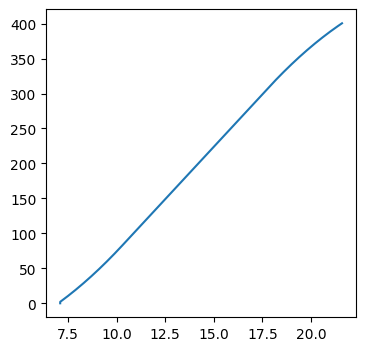

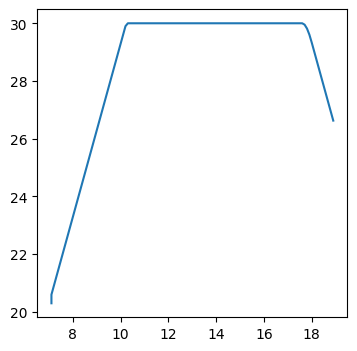

In [8]:
cars = vfr_simulation.CARS
car_0 = cars[1]
xcors = car_0.xcorList
plt.figure(figsize = (4,4))
plt.plot(car_0.timeLog, car_0.xcorList)

vList = []
for i in range(len(xcors)-1):
    v = (xcors[i+1] - xcors[i]) * 10
    vList.append(v)

print(vList[:120])

plt.figure(figsize=(4,4))
plt.plot(car_0.timeLog[:120], vList[:120])

In [13]:
# 動画作成
import cv2
import os
import re

# カレントディレクトリを取得
current_dir = os.getcwd()
# 画像フォルダのパス
image_folder = os.path.join(current_dir, 'images')
video_file = f'output_video_TTC={TTC}.mp4'

# 正規表現でファイル名からtの値を抽出
def extract_t(filename):
    match = re.search(r't=(\d+\.\d+)', filename)
    if match:
        return float(match.group(1))
    return None

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = sorted(images, key=lambda x: extract_t(x))

# 画像から動画を作成
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# 動画ライターを設定
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_file, fourcc, 5, (width, height))  # フレームレートを5fpsに設定

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

# リソースを解放
cv2.destroyAllWindows()
video.release()

# ここから下はDebug用のセル

In [27]:
# ↑の DFRのシミュレーションでつっかえた時のデバッグ用のセル. これは適宜上に上げて良い

car_1 = CARS[14]
print("ETA",car_1.my_etas)
print("===  acc_itinerary =====")
print(car_1.acc_itinerary)
print(car_1.xcor)
print(car_1.v_x)

# print("acc:",car.acc_itinerary)
# table = simulation.reservation_table.eta_table
# print(table[table["car_idx"]<=4])

IndexError: list index out of range

In [7]:
import sys 
sys.path.append("../")
from utils.calc_distance_from_acc_itinerary import calc_distance_from_acc_itinerary
acc_itinerary = [{'acc': 0, 't_start': 29.113823476836664, 'v_0': 20, 't_end': 32.6, 'x_start': 0}, {'t_start': 32.6, 'acc': -3, 'v_0': 20.0, 't_end': 33.1}, {'t_start': 33.1, 'acc': 0, 'v_0': 18.5, 't_end': 45.120270270270275}, {'t_start': 45.120270270270275, 'acc': -3, 'v_0': 18.5, 't_end': 45.620270270270275}, {'t_start': 45.620270270270275, 'acc': 0, 'v_0': 17.0, 't_end': 52.745270270270275}, {'t_start': 52.745270270270275, 'acc': 2, 'v_0': 17.0, 't_end': 53.745270270270275}, {'t_start': 53.745270270270275, 'acc': 0, 'v_0': 19.0, 't_end': 56.804093799682036}, {'t_start': 56.804093799682036, 'acc': 2, 'v_0': 19.0, 't_end': 60.804093799682036}, {'t_start': 60.804093799682036, 'acc': 0, 'v_0': 27.0, 't_end': 60.90316500711238}]
x = calc_distance_from_acc_itinerary(acc_itinerary, 53)
print(x)

436.1188231038803


In [6]:
def calc_x_at_pointed_time(pointed_time, carObj, current_time):
    acc_itinerary = carObj.acc_itinerary
    car_x = carObj.xcor
    # print(carObj.xcor, carObj.acc_itinerary)
    v_0 = carObj.v_x
    acc_itinerary_with_tend = carObj.acc_itinerary
    # print(f"carId: {carObj.car_idx}, acc_itinerary: {acc_itinerary_with_tend}")

    if len(acc_itinerary_with_tend) < 1:
        raise ValueError("acc_itinerary is empty")
    if len(acc_itinerary_with_tend) == 1:
        delta_t = pointed_time - current_time
        delta_x = v_0 * delta_t + 0.5 * acc_itinerary_with_tend[0]["acc"] * delta_t**2 + car_x
        return delta_x
    
    # 長さ2以上の場合
    for idx, accObj in enumerate(acc_itinerary_with_tend):
        if accObj["t_end"] < current_time:
            continue

        # この区間を全うできる場合.
        elif accObj["t_end"] <= pointed_time:
            delta_t = accObj["t_end"] - accObj["t_start"]
            if accObj["t_start"] < current_time:
                delta_t = accObj["t_end"] - current_time
            delta_x = v_0 * delta_t + 0.5 * accObj["acc"] * delta_t**2
            car_x += delta_x
            v_0 += delta_t * accObj["acc"]

        # 一番最後の区間の場合
        elif idx == len(acc_itinerary) - 1 or accObj["t_end"] > pointed_time:
            delta_t = pointed_time - accObj["t_start"]
            if accObj["t_start"] < current_time:
                delta_t = accObj["t_end"] - current_time
            delta_x = v_0 * delta_t + 0.5 * accObj["acc"] * delta_t**2
            car_x += delta_x
            break
        else:
            print(accObj, current_time, pointed_time, carObj.car_idx)
            raise ValueError("Something wrong")

    return car_x

calc_x_at_pointed_time(53, car_1, 48)

442.42488723520705